# Text Processing with spaCy

In [322]:
import gzip
import pickle
import numpy as np
from configparser import ConfigParser
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import re
import string
punctuations = string.punctuation
import warnings
import matplotlib.pyplot as plt

% matplotlib inline

# spaCy
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import spacy
    nlp = spacy.load('en')

# gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.preprocessing import Normalizer, StandardScaler

# logging for gensim (set to INFO)
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Read in tweet data from Mongodb

In [2]:
config = ConfigParser()
config.read('../config.ini')

client = MongoClient("mongodb://{}:{}@{}/{}".format(
                        config.get('MongoConfig', 'user'),
                        config.get('MongoConfig', 'password'),
                        config.get('MongoConfig', 'host'),
                        config.get('MongoConfig', 'db')
                        ), int(config.get('MongoConfig', 'port')))

In [3]:
db = client.twitter_db

In [4]:
db.collection_names()

['Init', 'tweets', 'favorited_tweets']

In [5]:
db.favorited_tweets.count()

1113805

In [6]:
cursor = db.favorited_tweets.find({}).limit(10000)

In [7]:
tweet_data = [document  for document in cursor]

In [8]:
rawtext = [tweet['full_text'] for tweet in tweet_data]

rawtext[:5]

["100% correct. Congress must still act. This Administration will end DACA and has the authority to do so -- it just didn't do it legally. Yet. https://t.co/HxiDhioeMY",
 '#DACA renewals continue. Sessions &amp; DOJ overreached to skip Courts of Appeal. Congress must still act. #CleanDreamActNow #DreamActNow #Dreamers https://t.co/jUrwbqNU6p',
 'More courageous young people leading! #DreamActNow #CleanDreamAct https://t.co/WT0OuZbOVR',
 "Philando Castile's mom slams NRA chief LaPierre as a hypocrite - NY Daily News https://t.co/RLpLAw4VzX",
 'From one of the teen activists from #Parkland #BanAssaultWeapons #BoycottNRA https://t.co/RjnUwmCypF']

## Normalize Text

#### Clean, Tokenize and Vectorize (maybe Stem, Lemmatize)

In [9]:
def clean_tweet(tweet):
    """
    Function to remove urls, numbers and punctuation, and make lowercase
    """
    no_url = re.sub(r'http\S+', '', tweet)
    clean = re.sub(r'[^\w\s]', '', no_url)
    
    result = ''.join([str(i).replace('\n', ' ').lower() for i in clean if not i.isdigit()])

    return result

In [10]:
cleantext = [clean_tweet(i) for i in rawtext]
print(rawtext[1], '\n')
print(cleantext[1])

#DACA renewals continue. Sessions &amp; DOJ overreached to skip Courts of Appeal. Congress must still act. #CleanDreamActNow #DreamActNow #Dreamers https://t.co/jUrwbqNU6p 

daca renewals continue sessions amp doj overreached to skip courts of appeal congress must still act cleandreamactnow dreamactnow dreamers 


In [11]:
def spacy_tokenizer(tweet):
    """
    Utility function to remove stopwords, ignore pronouns and tokenize words before vectorizing
    """
    doc = nlp(tweet)
    tokens = [token.orth_ for token in doc if 
              (token.orth_ not in stopwords and token.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ'])]
            
    return tokens

In [12]:
print(cleantext[0])

tokens_test = spacy_tokenizer(cleantext[0])
tokens_test

 correct congress must still act this administration will end daca and has the authority to do so  it just didnt do it legally yet 


['correct',
 'congress',
 'act',
 'administration',
 'end',
 'daca',
 'authority',
 'did']

In [13]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, 
                             ngram_range=(1,1))

In [14]:
vectorizer.fit(cleantext)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x121ef7268>, use_idf=True,
        vocabulary=None)

In [15]:
counts = vectorizer.transform(cleantext).transpose()

In [16]:
np.shape(counts)

(15661, 10000)

In [17]:
pd.DataFrame(counts.toarray(), vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a_clay_cahoon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aapi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aapiequalpay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
corpus = matutils.Sparse2Corpus(counts)

In [19]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [20]:
len(id2word)

15661

In [21]:
with open('../data/processed/word_features.pkl', 'wb') as wf:
    pickle.dump(id2word, wf)

## Dimensionality Reduction and Topic Modeling

### Try LDA to visualizae topic mappings using pyLDAvis
http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=0.51&term=

In [398]:
lda = models.LdaModel(corpus=corpus, num_topics=20, id2word=id2word, passes=5)

In [399]:
lda.print_topics()

[(0,
  '0.025*"cnnpolitics" + 0.010*"thank" + 0.008*"theleadeditor" + 0.007*"bull" + 0.007*"trump" + 0.006*"stop" + 0.006*"agree" + 0.006*"awesome" + 0.005*"storm" + 0.005*"rvawonk"'),
 (1,
  '0.009*"banassaultweapons" + 0.006*"presssec" + 0.006*"department" + 0.006*"guy" + 0.006*"search" + 0.005*"trump" + 0.004*"politicians" + 0.004*"racist" + 0.004*"continues" + 0.004*"wrong"'),
 (2,
  '0.009*"think" + 0.009*"did" + 0.006*"ll" + 0.006*"dead" + 0.006*"government" + 0.005*"man" + 0.005*"juddlegum" + 0.005*"resign" + 0.004*"media" + 0.004*"social"'),
 (3,
  '0.011*"cj_disabledvet" + 0.008*"bedford" + 0.007*"gop" + 0.007*"republicans" + 0.007*"mfrs" + 0.007*"guns" + 0.006*"thing" + 0.006*"makes" + 0.006*"weapons" + 0.006*"better"'),
 (4,
  '0.011*"hell" + 0.010*"facts" + 0.007*"love" + 0.006*"chicago" + 0.006*"russia" + 0.005*"daughter" + 0.005*"making" + 0.005*"catches" + 0.004*"inside" + 0.004*"mayor"'),
 (5,
  '0.008*"girl" + 0.007*"support" + 0.006*"need" + 0.006*"join" + 0.006*"wo" 

In [400]:
def find_topic_dist(tweet_index):
    print(rawtext[tweet_index], '\n')
    print(lda[corpus[tweet_index]])
    topic = max(lda[corpus[tweet_index]], key=lambda x:x[1])
    
    return topic

In [401]:
find_topic_dist(1000)

WEATHER ALERT: Areal Flood Watch for Perry, Morgan, Athens, Washington, Jackson and Vinton County until 1:00pm Sunday. https://t.co/rER0n11LOI 

[(0, 0.010975678), (1, 0.010975678), (2, 0.010975678), (3, 0.010975678), (4, 0.010975678), (5, 0.010975678), (6, 0.2328295), (7, 0.010975678), (8, 0.010975678), (9, 0.49471155), (10, 0.08587241), (11, 0.010975678), (12, 0.010975678), (13, 0.010975678), (14, 0.010975678), (15, 0.010975678), (16, 0.010975678), (17, 0.010975678), (18, 0.010975678), (19, 0.010975678)]


(9, 0.49471542)

In [402]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [403]:
tokens = [i[0] for i in vectorizer.vocabulary_.items()]
dictionary = corpora.Dictionary(np.array(tokens).reshape(-1, 1))
len(dictionary)

15661

In [404]:
data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/Users/tmoeller/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [410]:
pyLDAvis.show(data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [02/Mar/2018 20:50:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2018 20:50:24] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2018 20:50:24] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2018 20:50:24] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


# Topic Modeling for Smaller Data

Above, we created a term-document matrix for topic modeling with LDA. Because LSA and NMF require a document-term matrix, we'll create that below

In [135]:
dtm = vectorizer.fit_transform(cleantext)

In [214]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Try LSA

In [247]:
lsa = TruncatedSVD(n_components=6, random_state=42, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [248]:
lsa.explained_variance_ratio_

array([0.00347994, 0.00285627, 0.00333443, 0.00300378, 0.00301189,
       0.00233864])

In [249]:
print_top_words(lsa, vectorizer.get_feature_names(), 15)


Topic #0:
school shooting florida trump students high tv police gun student threats man county youtube did

Topic #1:
trump olympics winter county weather s flood gold alert usa warning pm team olympic youtube

Topic #2:
county flood weather warning alert pm police man cst yearold missing issued february youtube sat

Topic #3:
police man yearold missing tv s woman shot killed new son trump girl connectingyou says

Topic #4:
gold police usa man team medal olympics olympic hockey womens wins yearold curling missing shot

Topic #5:
realdonaldtrump s krassenstein edkrassen dwyer irdotnet nra iamororo know amp new good youtube high today



## Try NMF

In [678]:
nmf = NMF(n_components=11, random_state=42)

dtm_nmf = nmf.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [679]:
print_top_words(nmf, vectorizer.get_feature_names(), 55)


Topic #0:
school shooting florida students high student threats gun threat did officer sheriff tv arrested district post return parkland enter run armed following building resigns happen suspect killed charged violence kmanews fla middle threatening west control mass schools deputy entered response protest safety resource delay parents safest dubbed calls invention protects making america teen local canceled

Topic #1:
trump president ivanka teachers gun run thehill cnnpolitics campaign stop bump parade shootings military armed trumps stocks does house safetypindaily believe arming day ban safety americans governors big reelection says veterans tv white d manager wants amp illegitimate think public discusses said issue ball addresses funder twitter awards weapon sheriffs benefits russia memo seeing slams

Topic #2:
county flood weather warning alert pm cst sat issued washington watch advisory february saturday winter sunday coshocton vinton information marion d madison guernsey athens

The art is in first decideing what nubmer of topics to select and then in assigning each topic a name, which I'll do below

In [686]:
topics = ['florida_shooting',
          'president_and_policies',
          'local_weather',
          'local_crime',
          'olympics',
          'pundits_and_trolls',
          'local_news',
          'foreign_affairs',
          'random',
          'billy_dies',
          'taxes']

In [687]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(dtm_nmf)

In [688]:
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = dtm_nmf.argmax(axis=1)

In [689]:
from matplotlib import patches

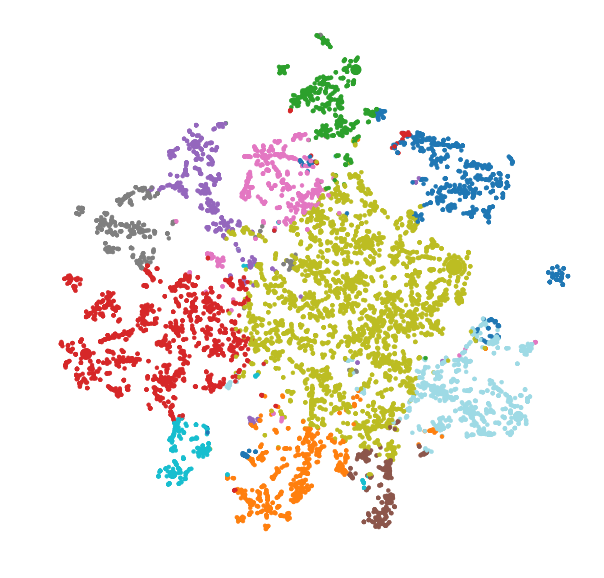

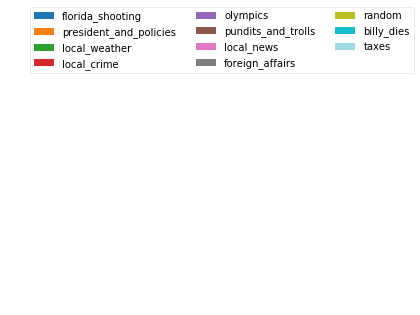

In [ ]:
###code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
    
legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=15,c=data['hue'],cmap="tab20")
plt.axis('off')
plt.show()

# Show legend - need to reformat
colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(patches.Ellipse((0, 0), 1, 1, fc=color))
 
plt.legend(legend_list,topics,loc=(0,1),ncol=3, facecolor="white")
plt.axis('off')
plt.show()

### Try plotting in 3D

In [ ]:
tsne = TSNE(n_components=3, random_state=3211)
tsne_result = tsne.fit_transform(dtm_nmf)

In [ ]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

tsne_result_scaled_df = pd.DataFrame(tsne_result_scaled,columns=['x','y','z'])
tsne_result_scaled_df['hue'] = dtm_nmf.argmax(axis=1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation


In [ ]:
label_to_id_dict = {v:i for i,v in enumerate(list(topics))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

label_ids = np.array([label_to_id_dict[id_to_label_dict[x]] for x in tsne_result_scaled_df['hue']])

In [ ]:
fig = plt.figure(figsize=(25,25), facecolor='white')
ax = fig.add_subplot(111,projection='3d')
ax.set_facecolor((1,1,1))
ax.xaxis.set_pane_color((1,1,1))
ax.yaxis.set_pane_color((1,1,1))
ax.zaxis.set_pane_color((1,1,1))

plt.grid()
plt.rcParams['grid.color'] = "grey"

nb_classes = len(np.unique(label_ids))
    
for label_id in np.unique(label_ids):
    ax.scatter(tsne_result_scaled[np.where(label_ids == label_id), 0],
                tsne_result_scaled[np.where(label_ids == label_id), 1],
                tsne_result_scaled[np.where(label_ids == label_id), 2],
                alpha=0.8,
                color= plt.cm.tab20(label_id / float(nb_classes)),
                marker='o',
                s=40,
                label=id_to_label_dict[label_id])
    
lgnd = ax.legend(loc='best', prop={'size': 15}, facecolor="white")

for i, t in enumerate(topics):
    lgnd.legendHandles[i]._sizes = [100]

ax.view_init(25, 45)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)

### Try plotting interactive 3D

In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
plotly.tools.set_credentials_file(username=config.get('Plotly', 'user'), 
                                  api_key=config.get('Plotly', 'api_key'))
plotly.__version__

In [ ]:
text = [tw for tw in cleantext]
topic = [id_to_label_dict[id_] for id_ in label_ids]
statTooltips = ['<b>{}</b> <br> {}'.format(t, tw) for (t, tw) in zip(topic, text)]

In [ ]:
 data = [go.Scatter3d(
            x = tsne_result_scaled[:,0],
            y = tsne_result_scaled[:,1],
            z = tsne_result_scaled[:,2],
            mode='markers', 
            text=statTooltips,
            hoverinfo='none+none+none+text',
            marker=dict(
                color=plt.cm.tab20(label_ids/ float(nb_classes)),
                size=4,
                line=dict(
                    color=plt.cm.tab20(label_ids/ float(nb_classes)),
                    width=0.5
                ),
            ),
        )] 

In [ ]:
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# Plot clusters by political affiliation

Find how many tweets per user

In [550]:
from collections import Counter

users_tweets = [tw['user']['screen_name'] for tw in tweet_data]
print(len(set(users_tweets)), 'Distinct Users')
Counter(users_tweets).most_common(30)

106 Distinct Users


[('11AliveNews', 1440),
 ('2the_hill', 957),
 ('13wmaznews', 636),
 ('1310WIBA', 603),
 ('17DISH', 510),
 ('12NewsNow', 400),
 ('10TV', 391),
 ('4029news', 332),
 ('2fishie', 311),
 ('23ABCNews', 308),
 ('2016yearofcrap', 281),
 ('1200WOAI', 242),
 ('1a', 197),
 ('1370wspd', 186),
 ('1215Deb', 174),
 ('1055WERC', 160),
 ('2dagmarDagmar', 160),
 ('25Barnett', 155),
 ('2014Taxes', 154),
 ('1059KNRS', 146),
 ('1011_News', 142),
 ('1210WPHT', 135),
 ('1510wlac', 124),
 ('1057thehawk', 111),
 ('1871Chicago', 99),
 ('1010WINS', 96),
 ('1470WMBD', 96),
 ('1nancyschindler', 93),
 ('25NewsWEEK', 89),
 ('12ossT', 84)]

Hmmm, because it seems like these top users all have a number in the beginning of their handle, there seem to be more news or organization outlets than normal people. (I might want to radomize this to get less news organizations)

Let's have a look at the assumed political affiliation of these organizations as determined by our legislative 'likes'

In [529]:
# Read in political affiliation by user 
favorited_users = pd.read_pickle('../data/interim/favorited_users.pickle')


In [530]:
favorited_users.head()

party,user.screen_name,Democrat,Independent,Republican,D,I,R,party,max_percent,max_count,official
0,008jck,1.0,0.0,0.0,100.0,0.0,0.0,D,100,1,False
1,00abster,0.0,0.0,1.0,0.0,0.0,100.0,R,100,1,False
2,00butterflies,1.0,0.0,0.0,100.0,0.0,0.0,D,100,1,False
3,05JMan,0.0,0.0,1.0,0.0,0.0,100.0,R,100,1,False
4,07shari22,1.0,0.0,0.0,100.0,0.0,0.0,D,100,1,False


In [531]:
favd_party_dict = {screen_name:party for (screen_name, party) 
                                       in zip(favorited_users['user.screen_name'],
                                             favorited_users['party'])}

Find how many tweets in each party

In [537]:
tweet_party = [favd_party_dict[tw['user']['screen_name']] for tw in tweet_data]

In [543]:
Counter(tweet_party)

Counter({'D': 4185, 'R': 5815})

Let's make the same 2D topic plot we did above but instead of coloring by topic let's color by the assumed political affiliation to see if there are differences in party density between the two classes

In [575]:
#tsne_embedding['party'] = [(1, 0, 0) if tw=='R' else (0, 0, 1) for tw in tweet_party]
tsne_embedding['party'] = ['red' if tw=='R' else 'blue' for tw in tweet_party]

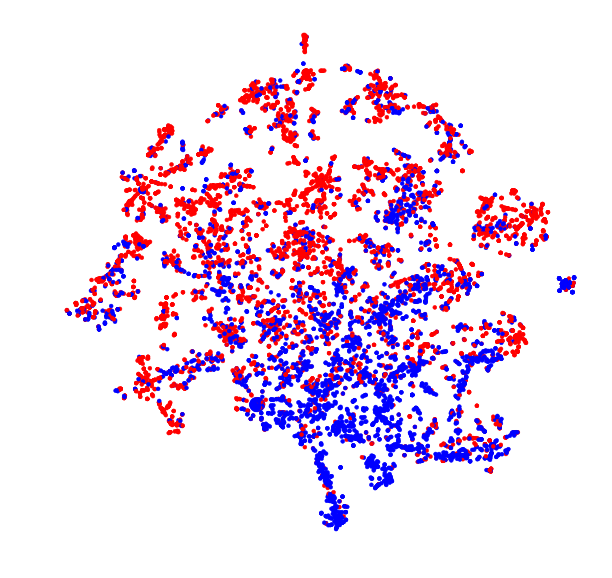

In [577]:
###code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
    
legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=15,color=data['party'])
plt.axis('off')
plt.show()